In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot

In [20]:
# Constants for the fiducial cut calculations
scoringPlaneZ = 239.9985
ecalFaceZ = 247.932
cell_radius = 5.0

def projection(Recoilx, Recoily, Recoilz, RPx, RPy, RPz, HitZ):
    """Project the recoil coordinates from the scoring plane to the ecal face."""
    x_final = Recoilx + RPx / RPz * (HitZ - Recoilz) if RPz != 0 else 0
    y_final = Recoily + RPy / RPz * (HitZ - Recoilz) if RPy != 0 else 0
    return (x_final, y_final)

def dist(cell, point):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((cell[0] - point[0])**2 + (cell[1] - point[1])**2)

def load_cellMap(filepath):
    """Load cell map from file."""
    cellMap = np.loadtxt(filepath, dtype={'names': ('id', 'x', 'y'), 'formats': ('i4', 'f4', 'f4')})
    print(f"Loaded detector info from {filepath}")
    return cellMap

def apply_fiducial_cut(recoilX, recoilY, recoilPx, recoilPy, recoilPz, cells):
    """Apply the fiducial cut to the given recoil data."""
    N = len(recoilX)
    f_cut = np.zeros(N, dtype=bool)
    for i in range(N):
        fiducial = False
        fXY = projection(recoilX[i], recoilY[i], scoringPlaneZ, recoilPx[i], recoilPy[i], recoilPz[i], ecalFaceZ)
        if not all(val == -9999 for val in [recoilX[i], recoilY[i], recoilPx[i], recoilPy[i], recoilPz[i]]):
            for cell in cells:
                if dist(cell, fXY) <= cell_radius:
                    fiducial = True
                    break
        f_cut[i] = fiducial
    return f_cut

In [21]:
# Load cell information
cells = load_cellMap('/home/aether_zhou_2023/LDMX-scripts/GraphNet/data/v14/cellmodule.txt')

# Path to the ROOT file
# file_path = '/home/vamitamas/NonFiducialSimu/events_nonfiducial_fullEcal_production.root'
file_path = '/home/duncansw/GraphNet_input/v14/8gev/v3_tskim/XCal_total/sig_eval/v14_8gev_0.1_XCal_total_40.root'

Loaded detector info from /home/j3lly/LDMX-scripts/GraphNet/data/v14/cellmodule.txt


In [31]:
# Open the ROOT file and load branches
with uproot.open(file_path) as file:
    tree = file["skimmed_events"]
    recoilX = tree['recoilX_'].array(library='np')
    recoilY = tree['recoilY_'].array(library='np')
    # recoilZ = tree['z_tsp_'].array(library='np')
    recoilPx = tree['recoilPx_'].array(library='np')
    recoilPy = tree['recoilPy_'].array(library='np')
    recoilPz = tree['recoilPz_'].array(library='np')

In [32]:
# Apply the fiducial cut
f_cut = apply_fiducial_cut(recoilX, recoilY, recoilPx, recoilPy, recoilPz, cells)

In [33]:
# Calculate and print statistics
fiducial_events = np.sum(f_cut)
total_events = len(f_cut)
ratio = fiducial_events / total_events
print(f"Total Events: {total_events}")
print(f"Fiducial Events: {fiducial_events}")
print(f"Fiducial/Total Events Ratio: {ratio:.4f}")

Total Events: 18440
Fiducial Events: 202
Fiducial/Total Events Ratio: 0.0110


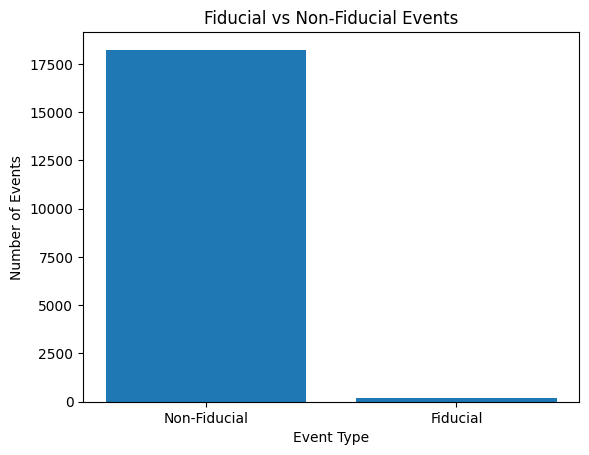

In [40]:
# Plotting the histogram of fiducial vs non-fiducial events
plt.hist(f_cut.astype(int), bins=[-0.5, 0.5, 1.5], rwidth=0.8) # label=['Non-Fiducial', 'Fiducial'])
plt.xticks([0, 1], ['Non-Fiducial', 'Fiducial'])
plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.title('Fiducial vs Non-Fiducial Events')
# plt.legend()
plt.show()